In [6]:
from picamera import PiCamera

In [8]:
import face_recognition
#画像を取得する
known_face_imgs = []
for path in ["../Biden.jpg", "../Elon.jpg", "../Messi.jpg", "../Trump.jpg"]:
    img = face_recognition.load_image_file(path)
    known_face_imgs.append(img)
#known_image = face_recognition.load_image_file("../Messi.jpg")

#それぞれの顔画像から特徴を抽出する
known_face_encodings = []
for image in known_face_imgs:
    encod = face_recognition.face_encodings(image)[0]
    known_face_encodings.append(encod)
#messi_encoding = face_recognition.face_encodings(known_image)[0]


#ぞれぞれの顔画像の特徴を比較する

#results = face_recognition.compare_faces([messi_encoding], unknown_encoding)
#print(results)

In [29]:
unknown_image = face_recognition.load_image_file("../unknown3.jpg")
face_locations = face_recognition.face_locations(unknown_image)
print(len(face_locations))
unknown_encodings = face_recognition.face_encodings(unknown_image, face_locations)
print(len(unknown_encodings))

2
2


In [31]:
from matplotlib import pyplot as plt

In [57]:
def draw_face_locations(img, locations, n):
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_axis_off()


    for i, (top, right, bottom, left) in zip(n, locations):
        # 長方形を描画する。
        w, h = right - left, bottom - top
        ax.add_patch(plt.Rectangle((left, top), w, h, ec="r", lw=2, fill=None))
        ax.text(left, top,i)
    plt.show()

In [58]:
#結果を表示する
print(face_locations)
known_face_names = ["Biden", "Elon", "Messi", "Trump"]
face_names = []
for unknown_encoding in unknown_encodings:
    result = face_recognition.compare_faces(known_face_encodings, unknown_encoding)
    
    print(result)
    if True in result:
        first_match = result.index(True)
        name = known_face_names[first_match]
        #face_location = face_locations
    else:
        name = "unknown"
    face_names.append(name)

[(53, 259, 115, 197), (80, 619, 155, 544)]
[False, False, False, False]
[False, False, True, False]


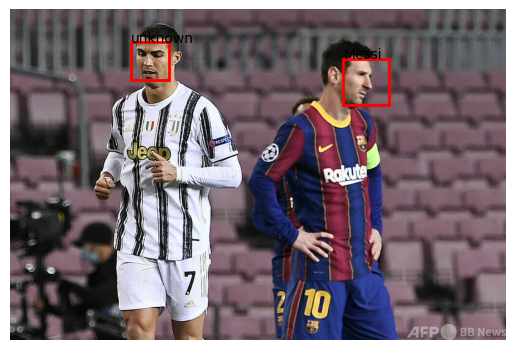

In [59]:
draw_face_locations(unknown_image, face_locations, face_names)